# MRI Tumor Detection

## Introduction

With cancer being so destructive, it is important to be able to diagnose cancer immediately to prevent the tumors from spreading and causing mayhem in the body. In particular, brain tumors are very debilitating and difficult to remove, and so it is imperative to develop technologies and methods for early detection. One such case is by developing machine learning algorithms to recognize tumors in MRI brain images. With some tumors being very obvious in the MRI image, some may not be as so obvious and could supplant a doctor's diagnosis by informing their ultimate diagnosis based on the classification of the machine learning algorithm. With a strongly accurate model, and high recall we can expect for this technology to be viable in the future and detect cancer early and treat it immediately.

## Method

Utilized the 'Brain MRI Images for Brain Tumor Classification' dataset in Kaggle.

## Code

### Initializing

#### Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
import cv2
import os

#### Viewing Images

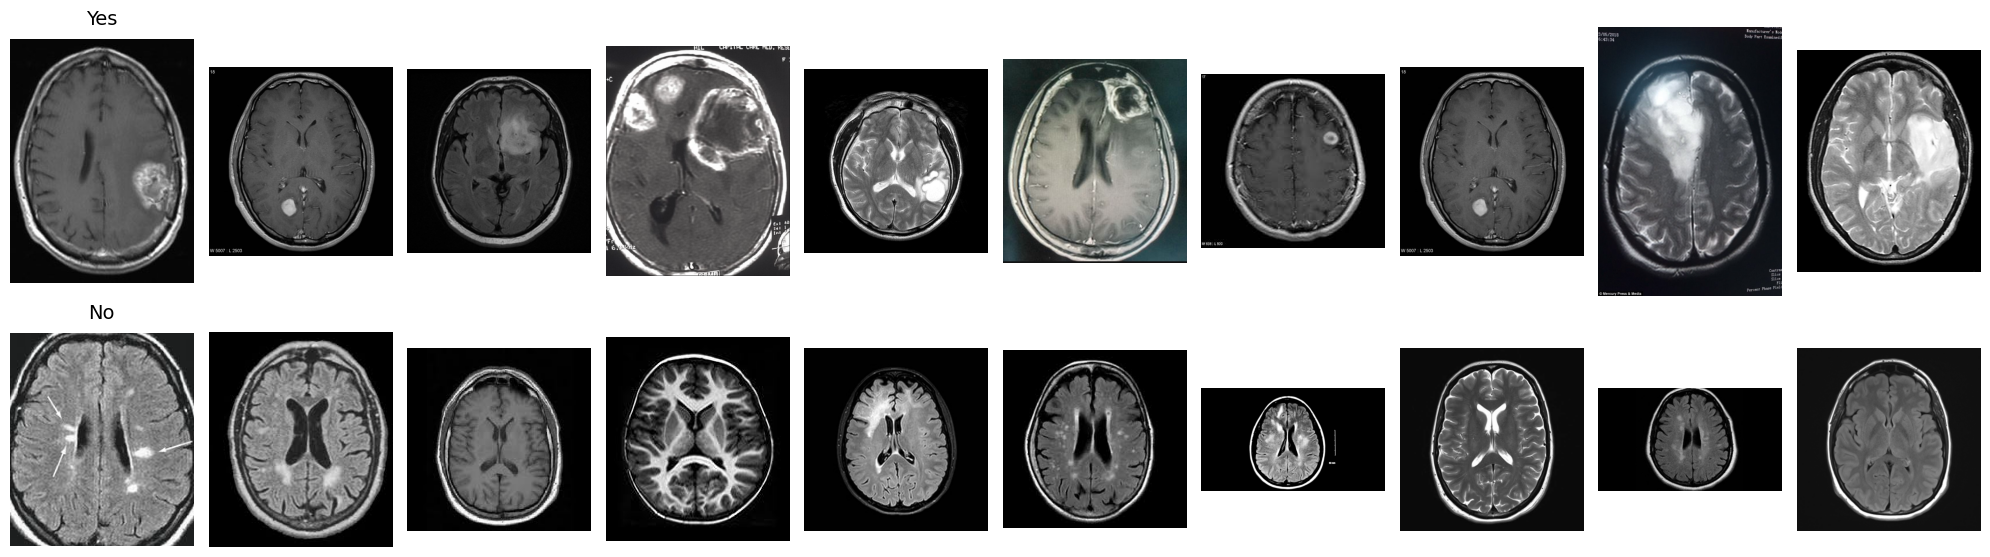

In [2]:
def image_display(folder1, folder2, num_images=10):

    fig, axs = plt.subplots(2, num_images, figsize=(20, 6))
    axs = axs.flatten()
    
    folders = [folder1, folder2]
    labels = ['Yes', 'No']
    
    for i, folder in enumerate(folders):
        
        count = 0
        
        for file in os.listdir(folder):

            if count >= num_images:
                break
            image = os.path.join(folder, file)
            image = cv2.imread(image)
            axs[i * num_images + count].imshow(image)
            axs[i * num_images + count].axis('off')
            count += 1
        axs[i * num_images].set_title(labels[i], fontsize=14, pad=10)
        
    plt.tight_layout()
    plt.show()


image_display('Yes', 'No')

### Preprocessing

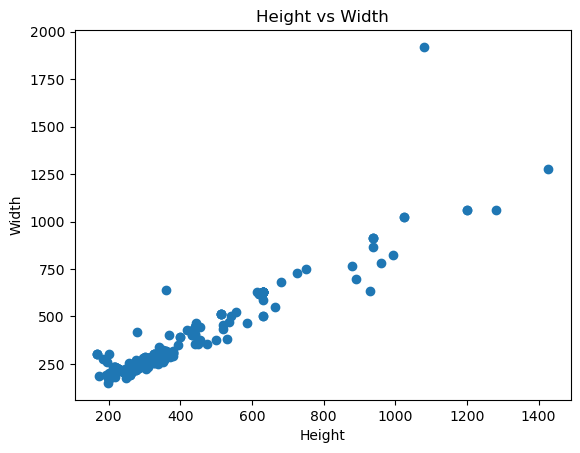

331
278


In [3]:
def image_sizes(folder1, folder2):

    folders = [folder1, folder2]
    heights = []
    widths = []
    for folder in folders:
        
        for file in os.listdir(folder):

            image = os.path.join(folder, file)
            image = cv2.imread(image)
            height, width = image.shape[:2]
            heights.append(height)
            widths.append(width)


    mean_heights = math.floor(np.median(heights))
    mean_widths = math.floor(np.median(widths))
    
    return heights, widths, mean_heights, mean_widths

heights, widths, mean_heights, mean_widths = image_sizes('Yes', 'No')
plt.scatter(heights, widths)
plt.title('Height vs Width')
plt.xlabel('Height')
plt.ylabel('Width')
plt.show()

print(mean_heights)
print(mean_widths)
mean_heights = 300
mean_widths = 300

In [4]:
def imaging(folder, label):

    images = []
    labels = []
    
    for file in os.listdir(folder):
        
        image_path = os.path.join(folder, file)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (mean_heights, mean_widths)) # how to know how to resize
        images.append(image)
        labels.append(label)
        
    images = np.array(images)
    labels = np.array(labels)
        
    return images, labels
    
tumor_X, tumor_y = imaging('Yes', 1)
no_tumor_X, no_tumor_y = imaging('No', 0)

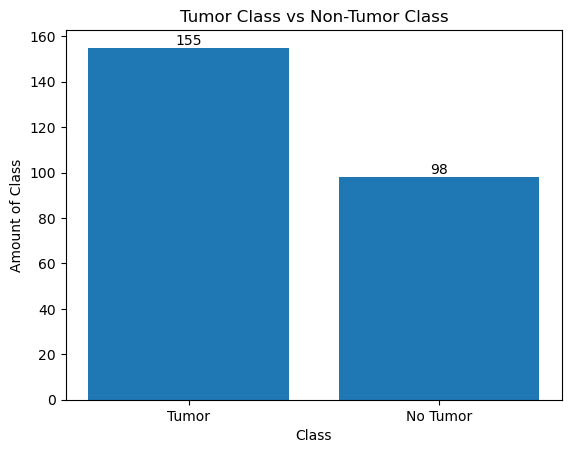

In [5]:
x = ['Tumor', 'No Tumor']
heights = [tumor_X.shape[0], no_tumor_X.shape[0]]
bars = plt.bar(x=x, height=heights)
plt.title('Tumor Class vs Non-Tumor Class')
plt.xlabel('Class')
plt.ylabel('Amount of Class')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, '%d' % int(height), ha='center', va='bottom')
    
plt.show()

There is a class imbalance present. 155 tumor images, and 98 no tumor images.

In [6]:
def augmentation(folder):

    files = os.listdir(folder)
    images = random.sample(files, 57)
    augmented = []

    for image in images:

        image = os.path.join(folder, image)
        image = cv2.imread(image)
        image = cv2.resize(image, (mean_heights, mean_widths))
        augment = cv2.flip(image, 1)
        augmented.append(augment)

    augmented = np.array(augmented)
    labels = len(augmented) * [0]
    labels = np.array(labels)
    
    return augmented, labels

    
augmented, labels = augmentation('No')

In [8]:
from sklearn.utils import shuffle

def add_shuffle(X1, X2, Xa, y1, y2, ya):
    #print(
    X = np.concatenate((X1, X2, Xa), axis=0)
    y = np.concatenate((y1, y2, ya), axis=0)
    #X = pd.DataFrame(X)
    #y = pd.DataFrame(y)
    X, y = shuffle(X, y)
    
    return X, y

X, y = add_shuffle(tumor_X, no_tumor_X, augmented, tumor_y, no_tumor_y, labels)

In [9]:
X = X / 255

### Classification

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, Flatten, Dropout, MaxPooling2D, Dense, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def convolutional(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    #X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
    model = models.Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(mean_heights, mean_widths, 3)))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    def plot_learning_curves(history):

        plt.figure(figsize=(10, 8))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'][1:])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.show()
        
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])
    
    plot_learning_curves(history)
    
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    eval = model.evaluate(X_test, y_test)
    
    return acc, pre, rec, f1, cr, eval

## Results

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4767 - loss: 0.9579 - val_accuracy: 0.4800 - val_loss: 0.7040
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6152 - loss: 0.6566 - val_accuracy: 0.7600 - val_loss: 0.5973
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6879 - loss: 0.5804 - val_accuracy: 0.7400 - val_loss: 0.5754
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7477 - loss: 0.5328 - val_accuracy: 0.6800 - val_loss: 0.6618
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7638 - loss: 0.5036 - val_accuracy: 0.7600 - val_loss: 0.5983
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7630 - loss: 0.5261 - val_accuracy: 0.7800 - val_loss: 0.5935
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7883 - loss: 0.4429 - val_accuracy: 0.7800 - val_loss: 0.5633
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8199 - loss: 0.4327 - val_accuracy: 0.8000 - val_loss: 0.5171


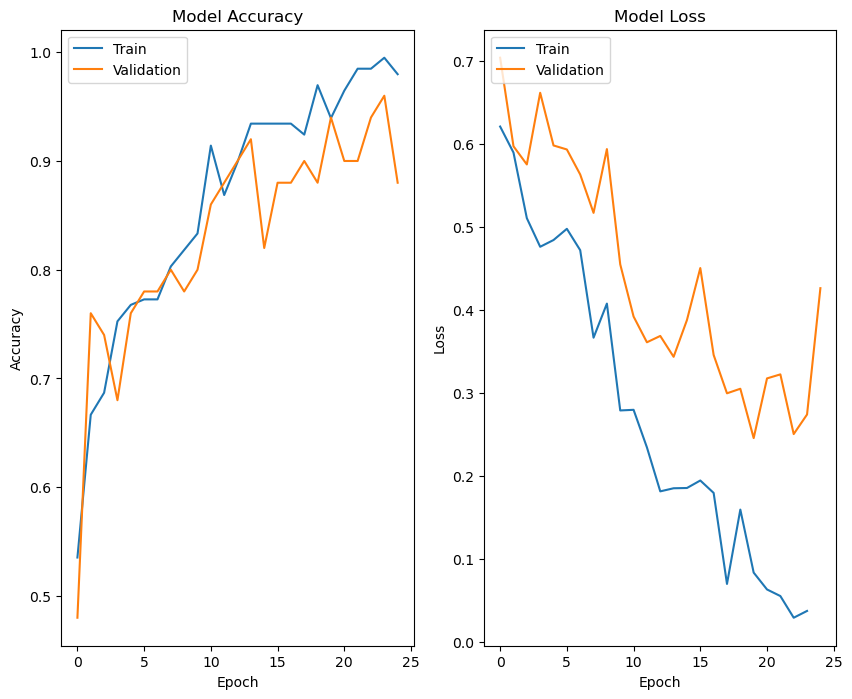

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step - accuracy: 0.9257 - loss: 0.3516
acc0.9354838709677419
pre0.9024390243902439
rec1.0
f10.9487179487179487
cr              precision    recall  f1-score   support

           0       1.00      0.84      0.91        25
           1       0.90      1.00      0.95        37

    accuracy                           0.94        62
   macro avg       0.95      0.92      0.93        62
weighted avg       0.94      0.94      0.93        62

eval[0.32375115156173706, 0.9354838728904724]


In [13]:
acc, pre, rec, f1, cr, eval = convolutional(X, y)
print('acc' + str(acc))
print('pre' + str(pre))
print('rec' + str(rec))
print('f1' + str(f1))
print('cr' + str(cr))
print('eval' + str(eval))

## Discussion

In [ ]:
# high precision means we have low false positives
# high recall means we have low false negatives
# for diagnosing diseases we want to try to prioritize the maximization of recall because we do not want to have false negatives
# as this could mean we are not treating people who need to be treated

#precision = 0.75
#recall = 1.0

# acc = 0.82
# pre = 0.83
# rec = 0.86
# f1 = 0.85

When dealing with medical diagnosis tasks, it is important to keep not only accuracy high, but also the recall metric because it is imperative that people that do have cancer are classified as so. If recall metric was low, the classification would result in some false negatives, meaning the patients should have been classified as having cancer but weren't, therefore allowing the cancer to worsen. Therefore we need to prioritize recall more than any other factor. 

The Convolutional Neural Network model architecture I developed has 4 convolutional layers with increasing filters. The first layers are able to capture simple features from the images like edges or textures. As the layers get deeper the model begins to learn more advanced features and complex data relationships. Following every convolutionlal layer is a pooling layer that is able to reduce the spatial dimensions of the feature map while only retaining the most important information. After the convolutional layers, there is a flattening operation that collapses the spatial structure of height, width, channels to a one-dimensional vector ready to be inputted into a dense layer. The dense layer has 128 neurons that are able to learn global relationships between different features. It is preceded and followed by a dropout operation that is able to prevent the model from overfitting onto the training data and preventing proper generalization to unseen data. The last layer is a dense layer with only one neuron that is able to classify 0 for a negative classification of tumors and 1 for a positive classification of tumors. The model was trained using an Adam optimizer which has an adaptive learning rate and momentum that allows for an improved convergence and stability during training. The binary crossentropy loss function was also used which penalizes large deviations from the true label. Lower values indicate better predictions as the predicted label is close to the true label. Visualizing the CNN model's performance, we see that the training and validation algorithms increase in accuracy at a similar rate, as well as with the decreasing of loss. 

This architecture resulted in an accuracy of 94% and a recall of 100% on the testing dataset. This means that all positive cases were classified correctly. The performance of this model exceeded expectations and is a valid trained model to be used on unseen data. Some future improvements I would like to work on is tuning the hyperparameters, like dropout rates and perhaps different learning rates that could potentially prevent overfitting and help the model converge better. I would also like to